# 395T Assignments 4 NLP  

### Student ID: cl52559

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

The assignment will extract discharged summary related to Moya Moya, Stroke, and TIA (ICD9_CODE: 4375, V171, V1254).  

In [2]:
import pandas as pd
noteevents_file = "/content/drive/MyDrive/MSAI/395T AI in Healthcare/Week_7/NOTEEVENTS.csv.gz"
diagnosis_file = "/content/drive/MyDrive/MSAI/395T AI in Healthcare/Week_7/DIAGNOSES_ICD.csv.gz"

In [3]:
notes = pd.read_csv(noteevents_file , compression='gzip')

<ipython-input-3-60f89b89c9e0>:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv(noteevents_file , compression='gzip')


In [4]:
diagnoses = pd.read_csv(diagnosis_file , compression='gzip')
diagnoses = diagnoses[diagnoses['ICD9_CODE'].isin(['4375', 'V1254', 'V171'])]

#### Most of the diagnoses for stroke are depends on radiology and echocardiogram report

In [58]:
data = pd.merge(notes, diagnoses, on='HADM_ID')
discharge_notes = data.loc[data['CATEGORY'].isin(['Discharge summary','Radiology', 'Echo']), ['TEXT']]
discharge_notes.to_csv('moya_moya_discharges.csv')


##  Embeddings

In [14]:
!pip install transformers


ERROR: Could not find a version that satisfies the requirement scipacy (from versions: none)
ERROR: No matching distribution found for scipacy


In [17]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 5.7 MB/s eta 0:00:00
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.4.0-py3-none-any.whl size=125666862 sha256=23d92a4b7994893484ba79e663f24b5be2454217fcdd64c3f58fdda45eca2e9c
  Stored in directory: /root/.cache/pip/wheels/c3/f5/32/313d08b812c91abeb6fb1d3b0f8fd69687c30c3a9d38288e4c
Successfully built en_ner_bc5cdr_md
  Atte


### Create functions

In [6]:
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

def get_word_indeces(tokenizer, text, word):
    '''
    Determines the index or indeces of the tokens corresponding to `word`
    within `text`. `word` can consist of multiple words, e.g., "cell biology".

    Determining the indeces is tricky because words can be broken into multiple
    tokens. I've solved this with a rather roundabout approach--I replace `word`
    with the correct number of `[MASK]` tokens, and then find these in the
    tokenized result.
    '''
    # Tokenize the 'word'--it may be broken into multiple tokens or subwords.
    word_tokens = tokenizer.tokenize(word)

    # Create a sequence of `[MASK]` tokens to put in place of `word`.
    masks_str = ' '.join(['[MASK]']*len(word_tokens))

    # Replace the word with mask tokens.
    text_masked = text.replace(word, masks_str)
    print(text_masked[:-1])
    # `encode` performs multiple functions:
    #   1. Tokenizes the text
    #   2. Maps the tokens to their IDs
    #   3. Adds the special [CLS] and [SEP] tokens.
    input_ids = tokenizer.encode(text_masked)
    print(input_ids)
    # Use numpy's `where` function to find all indeces of the [MASK] token.
    mask_token_indeces = np.where(np.array(input_ids) == tokenizer.mask_token_id)[0]

    return mask_token_indeces


def get_embedding(b_model, b_tokenizer, text, word=''):
    '''
    Uses the provided model and tokenizer to produce an embedding for the
    provided `text`, and a "contextualized" embedding for `word`, if provided.
    '''

    # If a word is provided, figure out which tokens correspond to it.
    if not word == '':
        word_indeces = get_word_indeces(b_tokenizer, text, word)

    # Encode the text, adding the (required!) special tokens, and converting to
    # PyTorch tensors.
    encoded_dict = b_tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        return_tensors = 'pt',     # Return pytorch tensors.
                )

    input_ids = encoded_dict['input_ids']

    b_model.eval()

    # Run the text through the model and get the hidden states.
    bert_outputs = b_model(input_ids)

    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers.
    with torch.no_grad():

        outputs = b_model(input_ids,output_hidden_states=True )
        # Evaluating the model will return a different number of objects based on
        # how it's  configured in the `from_pretrained` call earlier. In this case,
        # becase we set `output_hidden_states = True`, the third item will be the
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]

    # `hidden_states` has shape [13 x 1 x <sentence length> x 768]

    # Select the embeddings from the second to last layer.
    # `token_vecs` is a tensor with shape [<sent length> x 768]
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)

    # Convert to numpy array.
    sentence_embedding = sentence_embedding.detach().numpy()

    # If `word` was provided, compute an embedding for those tokens.
    if not word == '':
        # Take the average of the embeddings for the tokens in `word`.
        word_embedding = torch.mean(token_vecs[word_indeces], dim=0)

        # Convert to numpy array.
        word_embedding = word_embedding.detach().numpy()

        return (sentence_embedding, word_embedding)
    else:
        return sentence_embedding


def clean_text(text):
    # Tokenize the text into words
    words = text.split()

    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]

    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]

    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words))  # This is useful while plotting t-SNE plots

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Named Entity Recognition


In [8]:
import scispacy
import spacy

nlp = spacy.load("en_ner_bc5cdr_md") #en_ner_bc5cdr_md is a SciSpacy model explore more models in https://allenai.github.io/scispacy/

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


### Entity Visualizer

In [66]:
from spacy import displacy
import random

docs = discharge_notes['TEXT'].astype(str).values.tolist()

# Set the sample size
sample_size = 10

docs = random.sample(docs, sample_size)

all_notes_combined = '. '.join(docs)

for i in range(len(docs)):
  displacy.render(nlp(docs[i]), style="ent", jupyter=True)
  print(f"{'*'*100}")

****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


****************************************************************************************************


## Word2Vec


In [59]:
from gensim.models import word2vec

# Build corpus of all the entities extracted from the notes using spaCy model.
# The corpus is an array of arrays or list of lists where each of the nested lists corresponds to a note.

corpus=[]
docs = discharge_notes['TEXT'].astype(str).values.tolist()

for i in range(len(docs)):
  str_tokens=[]
  text = clean_text(docs[i])
  tokens= nlp(text).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus.append(list(str_tokens))

#### Train the vector

In [60]:
model = word2vec.Word2Vec(corpus, min_count=2)
model.train(corpus,total_examples=model.corpus_count, epochs=32)

(1339854, 2141440)

### Find similar words

In [76]:
model.wv.most_similar('paralysis', topn=10)

[('polysubstance', 0.9430533051490784),
 ('nitropaste', 0.9252641797065735),
 ('guiaic', 0.9231911301612854),
 ('orthostatic obstructive', 0.9200001358985901),
 ('ecgs', 0.9060283303260803),
 ('outlet obstruction', 0.9025662541389465),
 ('gastroenteritis', 0.899893045425415),
 ('integrilin plavix', 0.8997814655303955),
 ('lisinopril torsemide', 0.8971065878868103),
 ('brbpr', 0.8946153521537781)]

#### Show similarity between words

In [77]:
model.wv.similarity('stroke', 'paralysis')

0.65267074

#### View vectors

In [54]:
model.wv['stroke']

array([-0.07531578, -0.8604475 , -0.29066256, -0.04490632, -0.5558613 ,
        0.4110197 , -0.7345767 , -0.89370656, -0.3187852 ,  0.10075078,
        0.1000163 , -0.8248573 ,  0.5136857 , -0.7926501 , -0.13943256,
       -0.44616294, -0.2961366 , -0.95609075,  0.44692844,  0.7289425 ,
        0.30429828,  1.0593346 , -0.72770333,  0.6284184 ,  0.25643542,
        0.35361722, -0.62706906, -0.22061418, -0.0527389 ,  0.07546752,
       -0.5971245 ,  0.46078026,  0.08656196, -0.19620597, -0.36303475,
        0.9196212 , -0.28944486, -0.59969014,  0.448426  , -0.89466363,
       -0.11896339, -0.25997224,  0.1212667 , -0.02515099,  0.32690558,
        1.1284434 , -0.40048915, -0.104577  ,  0.613413  ,  0.5784629 ,
       -0.15882567, -0.7923066 , -0.5826467 , -0.16523975,  0.2510938 ,
       -0.01464216, -0.26669002, -0.52916175, -0.0993816 , -0.25254032,
       -0.4284854 ,  0.95120937, -0.19161831, -0.2483113 , -0.22954357,
        0.11149018, -0.854816  ,  0.11328854,  0.2678675 , -0.25

## Showing distances betweens corpus based on embeddings distance

In [91]:
bag_of_words = []

# Iterate through the sublists and combine the words
for sublist in corpus:
    bag_of_words.extend(sublist)

In [96]:
small_bags = random.sample(bag_of_words, 250)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


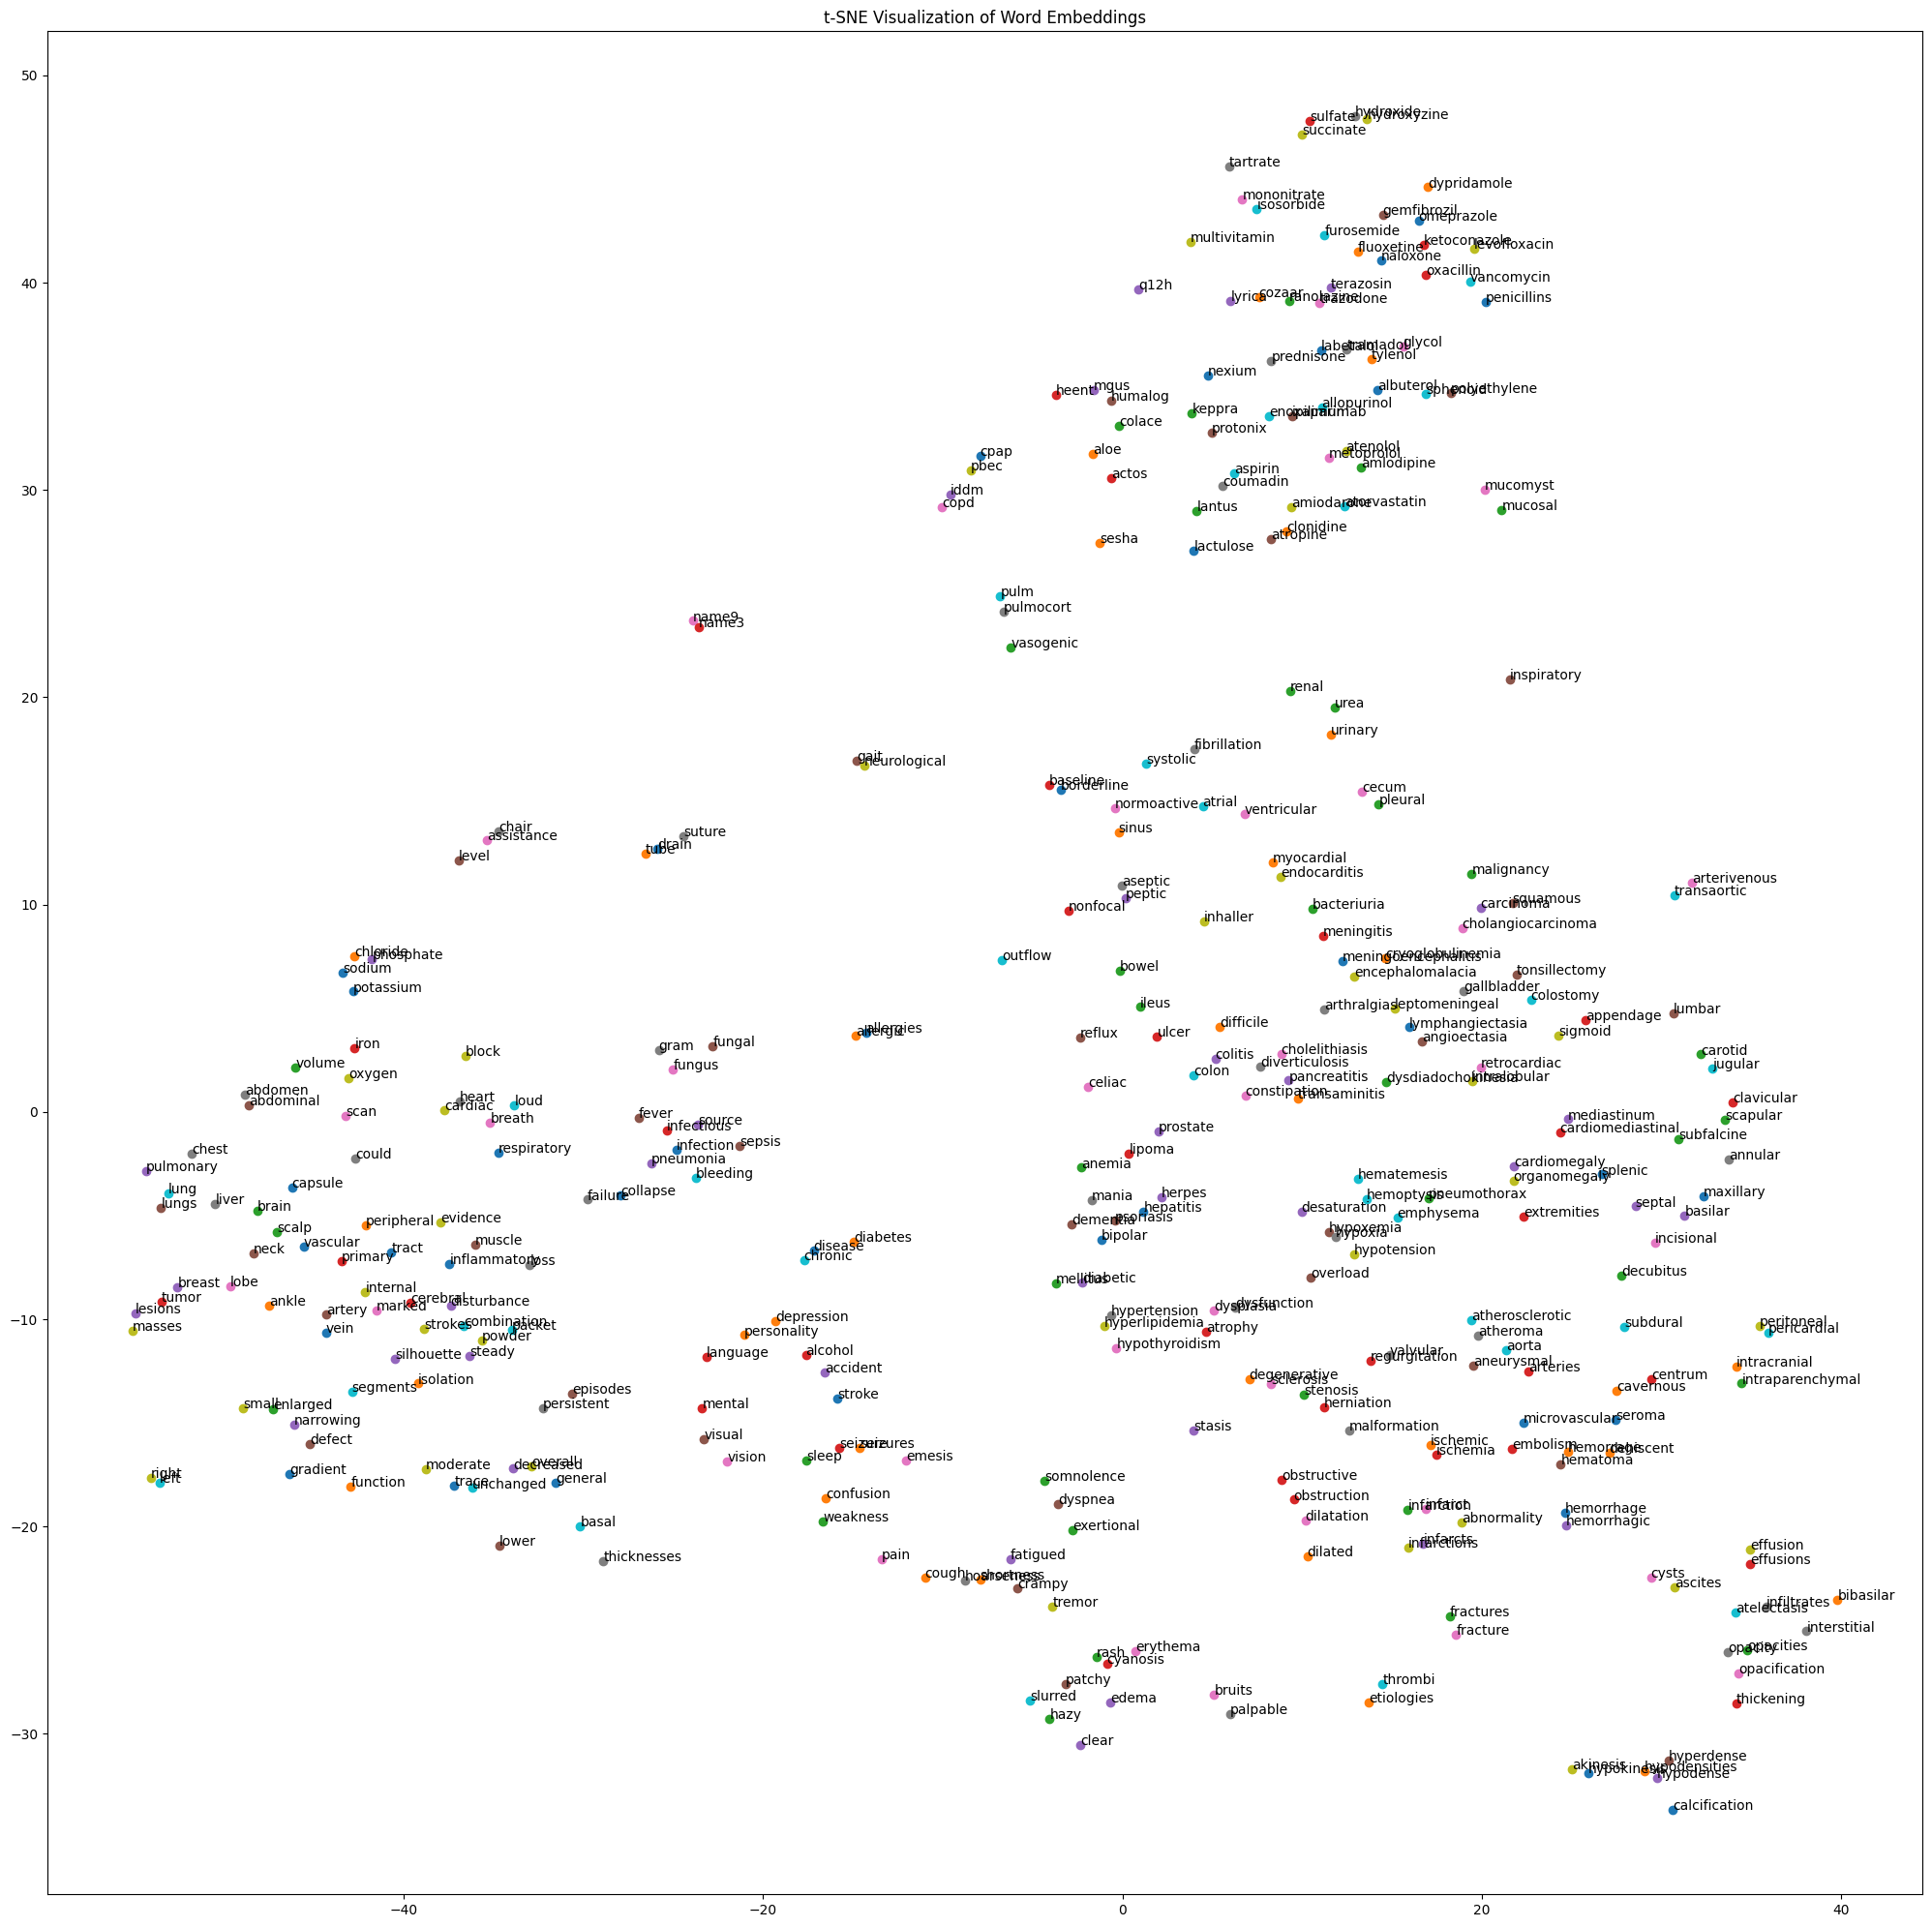

In [97]:
# Visualization of all notes using ClinicalBert
import numpy as np
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch

# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()


# Example input text
input_text = clean_text(' '.join(small_bags))

# Tokenize the input text using the BERT tokenizer
#input_tokens = clinical_tokenizer.tokenize(input_text)
input_tokens = input_text.split()
# Initialize an empty list to store word embeddings
word_embs = []

for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(25, 25))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()